In [2]:
import numpy as np


#import sys
#sys.path.append('path_to_dir') 

import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import confusion_matrix

from scepia.sc import (
    infer_motifs, 
    plot
)

%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(dpi=150)

-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.1
-----
Bio                         1.79
HTSeq                       1.99.2
PIL                         8.4.0
adjustText                  NA
anndata                     0.7.8
appdirs                     1.4.4
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boltons                     NA
brotli                      NA
bucketcache                 0.12.1
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.10
colorama                    0.4.4
concurrent                  NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
diskcache                   5.4.0
encodings                   NA
entrypoints                 0.3
fbpca                       NA
f

# Pre-process data

This tutorial is based on the `scanpy` tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html. It uses the 10X PBMC 3K data set, an analysis of peripheral blood mononuclear cells (PBMCs) from a healthy donor.

Preprocess your scRNA-seq data as you would normally do. This includes, for instance, normalization and batch correction.
To run `scepia` it is important to make sure of the following:

* Gene names are used in `adata.var_names`, not Ensembl identifiers or any other gene identifiers. Currently, the motifs are matched to genes by name. 
* The raw, log-transformed data is stored in `adata.raw`. Not all relevant transcription factors will be called as hypervariable genes, therefore `scepia` uses the raw data.
* The main `AnnData` object is filtered to contain the hypervariable genes.
* Louvain or Leiden clustering has been run.

The following steps are all straight from the `scanpy` tutorial. Important steps for `scepia` are marked.

In [3]:
#adata = sc.datasets.pbmc3k()
# load in a h5ad dataset that contains only raw data; not assays from imputed or SCT
adata = sc.read_h5ad("meta_subset_rw.h5ad")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

#mito_genes = adata.var_names.str.startswith('MT-')
#adata.obs['percent_mito'] = np.sum(
#    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
#adata.obs['n_counts'] = adata.X.sum(axis=1).A1

#adata = adata[adata.obs['nFeature_RNA'] < 2500, :]
#adata = adata[adata.obs['percent.mt'] < 0.05, :]

#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# SCEPIA: highly variable genes are called and adata is filtered
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata = adata[:, adata.var['highly_variable']]

#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

#sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

# SCEPIA: louvain clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.louvain(adata)

# Here we use UMAP for visualization, you can also use t-SNE
sc.tl.umap(adata)

#new_cluster_names = [
  #  'CD4 T', 'CD14+ Monocytes',
  #  'B1', 'CD8 T2',
  #  'B2', 'CD8 T3',
  #  'B3', 'CD8 T4',
  #  'B4', 'CD8 T6',
  #  'B8', 'CD8 T7',
  #  'B9', 'CD8 T8',
  #  'B10', 'CD8 T9',
  #  'B11', 'CD8 T20',
  #  'B12', 'CD8 T10',
  #  'B5',
  #  'NK', 'FCGR3A+ Monocytes',
  #  'Dendritic', 'Megakaryocytes']
#adata.rename_categories('louvain', new_cluster_names)

filtered out 1811 genes that are detected in less than 3 cells
computing PCA
    with n_comps=50
    finished (0:00:58)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 29 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


In [4]:
# Read in the scVI object
adata = sc.read_h5ad("fullcornea_scVI_postprocessing.h5ad")

In [5]:
#adata = sc.read_h5ad("pbmc3k.h5ad")
adata.obs

orig.ident  nCount_RNA  \
Collin_SRR12386359_AAACGAACAAGTTCGT-1  CollinSRR12386359     21239.0   
Collin_SRR12386359_AAACGAACATCAGTGT-1  CollinSRR12386359     21049.0   
Collin_SRR12386359_AAACGAATCGCCTTTG-1  CollinSRR12386359     13206.0   
Collin_SRR12386359_AAACGAATCTCGCTTG-1  CollinSRR12386359     21188.0   
Collin_SRR12386359_AAACGCTAGCCTATTG-1  CollinSRR12386359     15230.0   
...                                                  ...         ...   
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1  GautamSRR14742511      5251.0   
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1  GautamSRR14742511      7148.0   
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1  GautamSRR14742511      6107.0   
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1  GautamSRR14742511     17377.0   
Gautam_SRR14742511_TTTGTTGTCGGAGTAG-1  GautamSRR14742511      6494.0   

                                       nFeature_RNA  percent.mt   S.Score  \
Collin_SRR12386359_AAACGAACAAGTTCGT-1          4257   10.038137  0.016198   
Collin_SRR12386359_AAACGAACATCAGTGT-1          4207    9.572901 -0.035335   
Collin_SRR12386359_AAACGAATCGCCTTTG-1          3061    8.708163  0.036642   
Collin_SRR12386359_AAACGAATCTCGCTTG-1          4084    4.195771  0.014364   
Collin_SRR12386359_AAACGCTAGCCTATTG-1          3058   22.698621 -0.041253   
...                                             ...         ...       ...   
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1          2143    1.466387  0.002502   
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1          2194   18.102966  0.108062   
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1          2284   26.494187 -0.045893   
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1          4279   16.562122  0.075470   
Gautam_SRR14742511_TTTGTTGTCGGAGTAG-1          2406    3.356945 -0.042357   

                                       G2M.Score Phase  old.ident  \
Collin_SRR12386359_AAACGAACAAGTTCGT-1  -0.015478     S  cell_type   
Collin_SRR12386359_AAACGAACATCAGTGT-1  -0.016203    G1  cell_type   
Collin_SRR12386359_AAACGAATCGCCTTTG-1   0.016440     S  cell_type   
Collin_SRR12386359_AAACGAATCTCGCTTG-1   0.034211   G2M  cell_type   
Collin_SRR12386359_AAACGCTAGCCTATTG-1  -0.000649    G1  cell_type   
...                                          ...   ...        ...   
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1  -0.015173     S  cell_type   
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1  -0.044719     S  cell_type   
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1  -0.056643    G1  cell_type   
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1  -0.008741     S  cell_type   
Gautam_SRR14742511_TTTGTTGTCGGAGTAG-1  -0.073765    G1  cell_type   

                                      RNA_snn_res.0.15 seurat_clusters  ...  \
Collin_SRR12386359_AAACGAACAAGTTCGT-1                1               1  ...   
Collin_SRR12386359_AAACGAACATCAGTGT-1                1               1  ...   
Collin_SRR12386359_AAACGAATCGCCTTTG-1                1               1  ...   
Collin_SRR12386359_AAACGAATCTCGCTTG-1                3               3  ...   
Collin_SRR12386359_AAACGCTAGCCTATTG-1                4               4  ...   
...                                                ...             ...  ...   
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1               NA               9  ...   
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1               NA               4  ...   
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1               NA               4  ...   
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1               NA               4  ...   
Gautam_SRR14742511_TTTGTTGTCGGAGTAG-1               NA               9  ...   

                                      leiden_0.55 leiden_0.6  leiden_0.65  \
Collin_SRR12386359_AAACGAACAAGTTCGT-1           2          2            1   
Collin_SRR12386359_AAACGAACATCAGTGT-1           2          2            1   
Collin_SRR12386359_AAACGAATCGCCTTTG-1           2          2            1   
Collin_SRR12386359_AAACGAATCTCGCTTG-1           5          5           11   
Collin_SRR12386359_AAACGCTAGCCTATTG-1           3          3            3   
...             

In [70]:
# Select populations you want to run SCEPIA on (done in V3 of this script)
#adata = adata[adata.obs['leiden_anno'].isin(['LSC','LESC','LE','Cj','CE','CSSC','CF'])]

In [6]:
adata.obs[["louvain"]] = adata.obs[["leiden_anno"]]

In [7]:
adata.write_h5ad("processed_scepia_meta-atlas.h5ad")

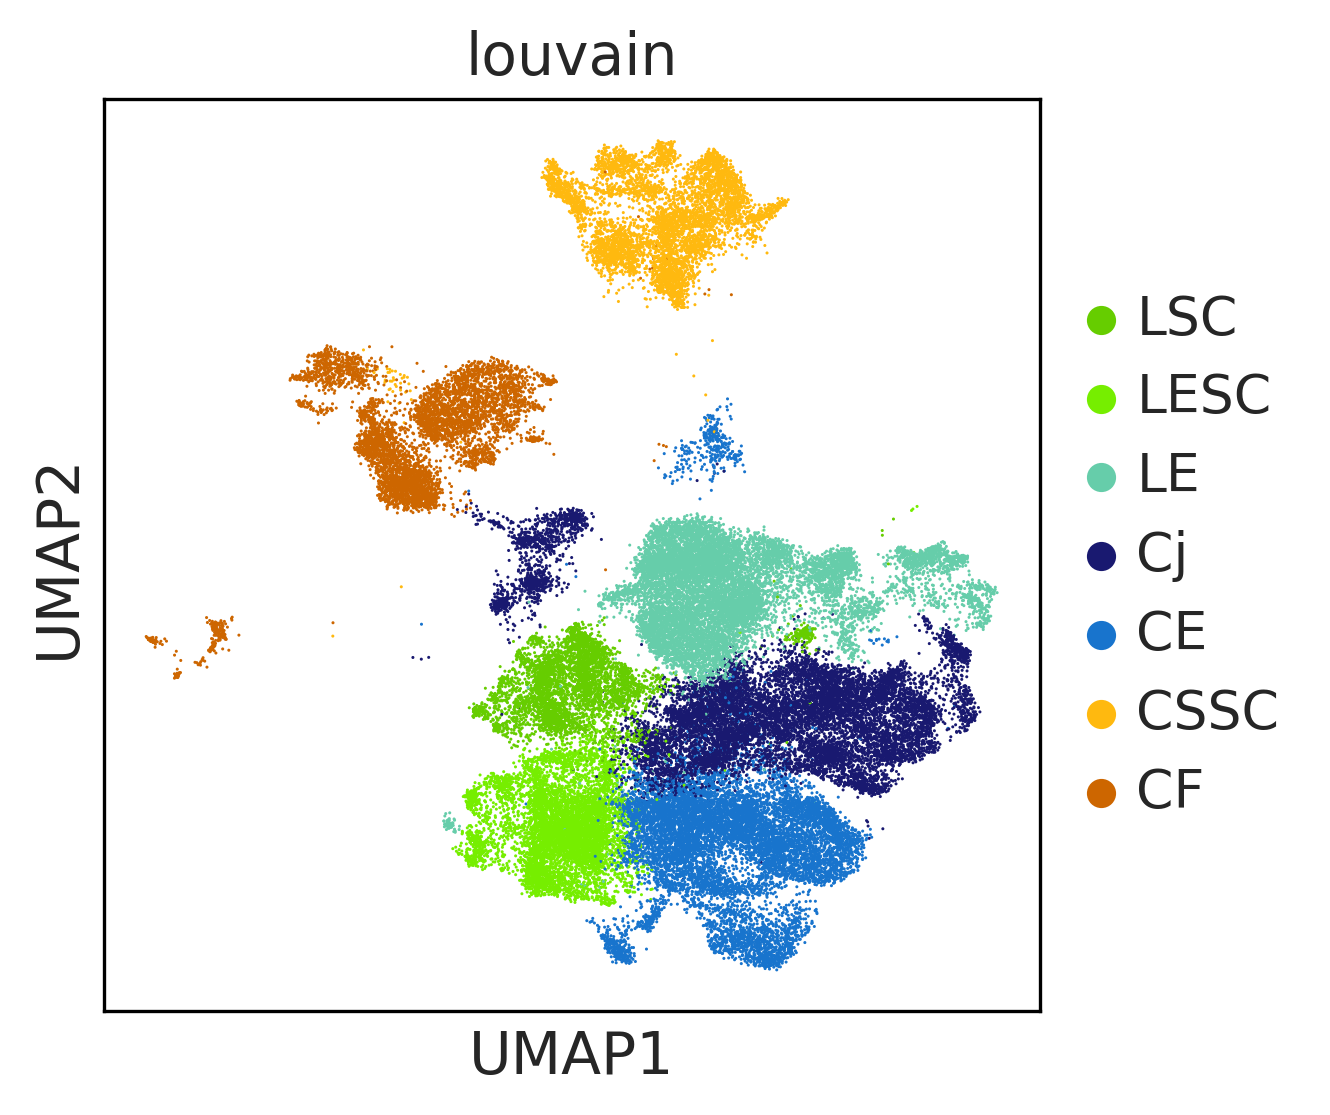

In [76]:
# sc.pl.umap(adata, color=["louvain"],
#     palette={
#         "CE": "#1874CD",
#         "CF": "#CD6600",
#         "Cj": "#191970",
#         "LE": "#66CDAA",
#        "CSSC": "#FFB90F",
#        "LSC": "#66CD00",
#        "LESC": "#76EE00",
#     },)

In [8]:
# Convert the raw data as the features again for the log transform
adata = sc.read_h5ad("processed_scepia_meta-atlas.h5ad")

In [9]:
adata = adata.raw.to_adata()

In [10]:
adata.X

<65036x27656 sparse matrix of type '<class 'numpy.float32'>'
	with 188012106 stored elements in Compressed Sparse Row format>

In [11]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [12]:
adata.X

<65036x27656 sparse matrix of type '<class 'numpy.float32'>'
	with 188012106 stored elements in Compressed Sparse Row format>

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.louvain(adata, use_weights=True)

adata.obs["leiden"] = adata.obs["louvain"]
adata.raw = adata

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 44 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:12)


In [14]:
adata.var[['highly_variable']]

highly_variable
HES4                   True
ISG15                  True
TNFRSF18               True
MXRA8                  True
MMP23B                 True
...                     ...
PPDPFL                 True
KRTAP4-8               True
PIP                    True
AC010327.4             True
CCL7                   True

[2744 rows x 1 columns]

In [15]:
adata.write_h5ad("postprocessed_scepia_meta-atlas.h5ad")

# Inference of motif activity using SCEPIA

Now you can run `infer_motifs()` from the `scepia` package. The first time you run `infer_motifs()`, `scepia` will download a data package. This will take some time, but the results will be saved in `~/.cache/scepia`. 

Currently, five data packages are available:


* `ENCODE.H3K27ac.human` - All H3K27ac experiments from ENCODE. Includes cell
  lines and tissues.
* `BLUEPRINT.H3K27ac.human` - All H3K27ac cell types from BLUEPRINT (mostly
  hematopoietic cell types)
* `Domcke.ATAC.fetal.human` - Fetal single cell-based ATAC-seq clusters from
  15 different organs ([Domcke et al, 2020](http://dx.doi.org/10.1126/science.aba7612)).
* `Cusanovich.ATAC.mouse` - ATAC-seq data of single cell-based clusters from 13
  adult mouse tissues ([Cusanovich et al, 2018](http://dx.doi.org/doi:10.1016/j.cell.2018.06.052)).
* `ENCODE.H3K27ac.mouse` - All H3K27ac experiments from mouse ENCODE.

For TF motifs, the default [GimmeMotifs](https://gimmemotifs.readthedocs.org) motif database is used, but you can also use other motif databases. For instance, `pfm="JASPAR2020_vertebrates"` or `pfm="HOMER"`. Alternatively, you can also supply a file name with your own motifs in PFM format.

By default, `infer_motifs()` uses 10,000 variable enhancers for motif analysis. You can change this using the `num_enhancers` argument. In any case, only the enhancers near (<100kb) the selected hypervariable genes will be used. 

After motif inference, scepia will calculate correlations between predicted motif activity and transcription factor expression. To scale these calculations also to higher cell numbers, scepia will first create a sketch of 2,500 cells using geosketch ([Hie, 2019](https://doi.org/10.1016/j.cels.2019.05.003)). You can change this number with the `n_sketch` parameter. The sketch is based on the PCA components stored in `adata.obsm['X_pca']`. Sometimes using more components will help to create a more representative sketch.

The correlation between motif and transcription factor is usually already very informative. However, cells that are similar will receive a similar cell type assignment and therefore a similar motif activity profile. On the other hand, cells that are similar will als tend to express similar TFs. This means that motifs will sometimes be highly correlated to TF expression, even if the motif is not relevant. Therefore, we generate random permutations of the motif activity and derive an empirical p-value. The number of permutations, 100,000 by default, is controlled with the `n_permutations` parameter.

All in all, most of the steps are not directly impacted by cell numbers.

In [16]:
adata = sc.read_h5ad("postprocessed_scepia_meta-atlas.h5ad")
infer_motifs(adata, dataset="ENCODE.H3K27ac.human", n_top_genes=2000)

# Use the following command to infer motif activity for JASPAR motifs:
# infer_motifs(adata, dataset="ENCODE.H3K27ac.human", pfm="JASPAR2020_vertebrates")

2022-05-02 14:58:58 - INFO - Loading reference data (gene).
2022-05-02 14:58:59 - INFO - Selecting reference cell types
2022-05-02 14:59:00 - INFO - Using 2000 hypervariable common genes
2022-05-02 14:59:10 - INFO - 50 out of 121 selected
2022-05-02 14:59:10 - INFO - Top 5:
2022-05-02 14:59:10 - INFO -  * keratinocyte
2022-05-02 14:59:10 - INFO -  * fibroblast of dermis
2022-05-02 14:59:10 - INFO -  * esophagus squamous epithelium
2022-05-02 14:59:10 - INFO -  * esophagus
2022-05-02 14:59:10 - INFO -  * foreskin keratinocyte
2022-05-02 14:59:10 - INFO - Annotating cells.


  0%|          | 0/65036 [00:00<?, ?it/s]

2022-05-02 15:14:52 - INFO - Linking variable genes to differential enhancers.
2022-05-02 15:15:04 - INFO - Loading reference data (enhancer).
2022-05-02 15:15:29 - INFO - inferring motif activity
2022-05-02 15:15:29 - INFO - Activity based on genome hg38
2022-05-02 15:15:32,627 - INFO - motif scanning (scores)
2022-05-02 15:15:32,627 - INFO - reading table
2022-05-02 15:16:04,000 - INFO - creating score table (z-score, GC%)


scanning:   0%|          | 0/10000 [00:00<?, ? sequences/s]

2022-05-02 15:17:55,752 - INFO - done
2022-05-02 15:17:55,753 - INFO - creating dataframe
2022-05-02 15:17:59,755 - INFO - Fitting BayesianRidge


  0%|          | 0/50 [00:00<?, ?it/s]

2022-05-02 15:22:48,492 - INFO - Done
2022-05-02 15:22:48 - INFO - calculating cell-specific motif activity
2022-05-02 15:22:49 - INFO - correlating motif activity with factors
2022-05-02 15:22:49 - INFO - including indirect and/or predicted factors
2022-05-02 15:22:50 - INFO - creating sketch of 2500 cells
2022-05-02 15:23:35 - INFO - calculating correlation of motif activity with 154 factors
2022-05-02 15:23:37 - INFO - calculating 100000 permutations


  0%|          | 0/60 [00:00<?, ?it/s]

2022-05-02 15:25:28 - INFO - calculating permutation-based p-values (all)
2022-05-02 15:25:43 - INFO - calculating permutation-based p-values (factor-specific)


  0%|          | 0/867 [00:00<?, ?it/s]

/vol/mbconda/julian/envs/scepia_050/lib/python3.9/site-packages/scipy/stats/stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
/vol/mbconda/julian/envs/scepia_050/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
2022-05-02 15:25:44 - INFO - Inferring factor activity.


  0%|          | 0/154 [00:00<?, ?it/s]

2022-05-02 15:27:23 - INFO - Done with motif inference.


In [17]:
#df = pd.read_feather("/home/julian/.cache/gimmemotifs/hg38.gcfreq.100.feather")
adata.write_h5ad("scanned_scepia_meta-atlas_02052022.h5ad")

/vol/mbconda/julian/envs/scepia_050/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster_annotation' as categorical
/vol/mbconda/julian/envs/scepia_050/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_annotation' as categorical


# Cell type annotation

The cell types of all single cells are annotated based on matching H3K27ac profiles. You can check this using the `cell_annotation` and the `cluster_annotation` properties that are stored in `adata.obs`. The `cluster_annotation` is just the majority vote of all cell types in the cluster.

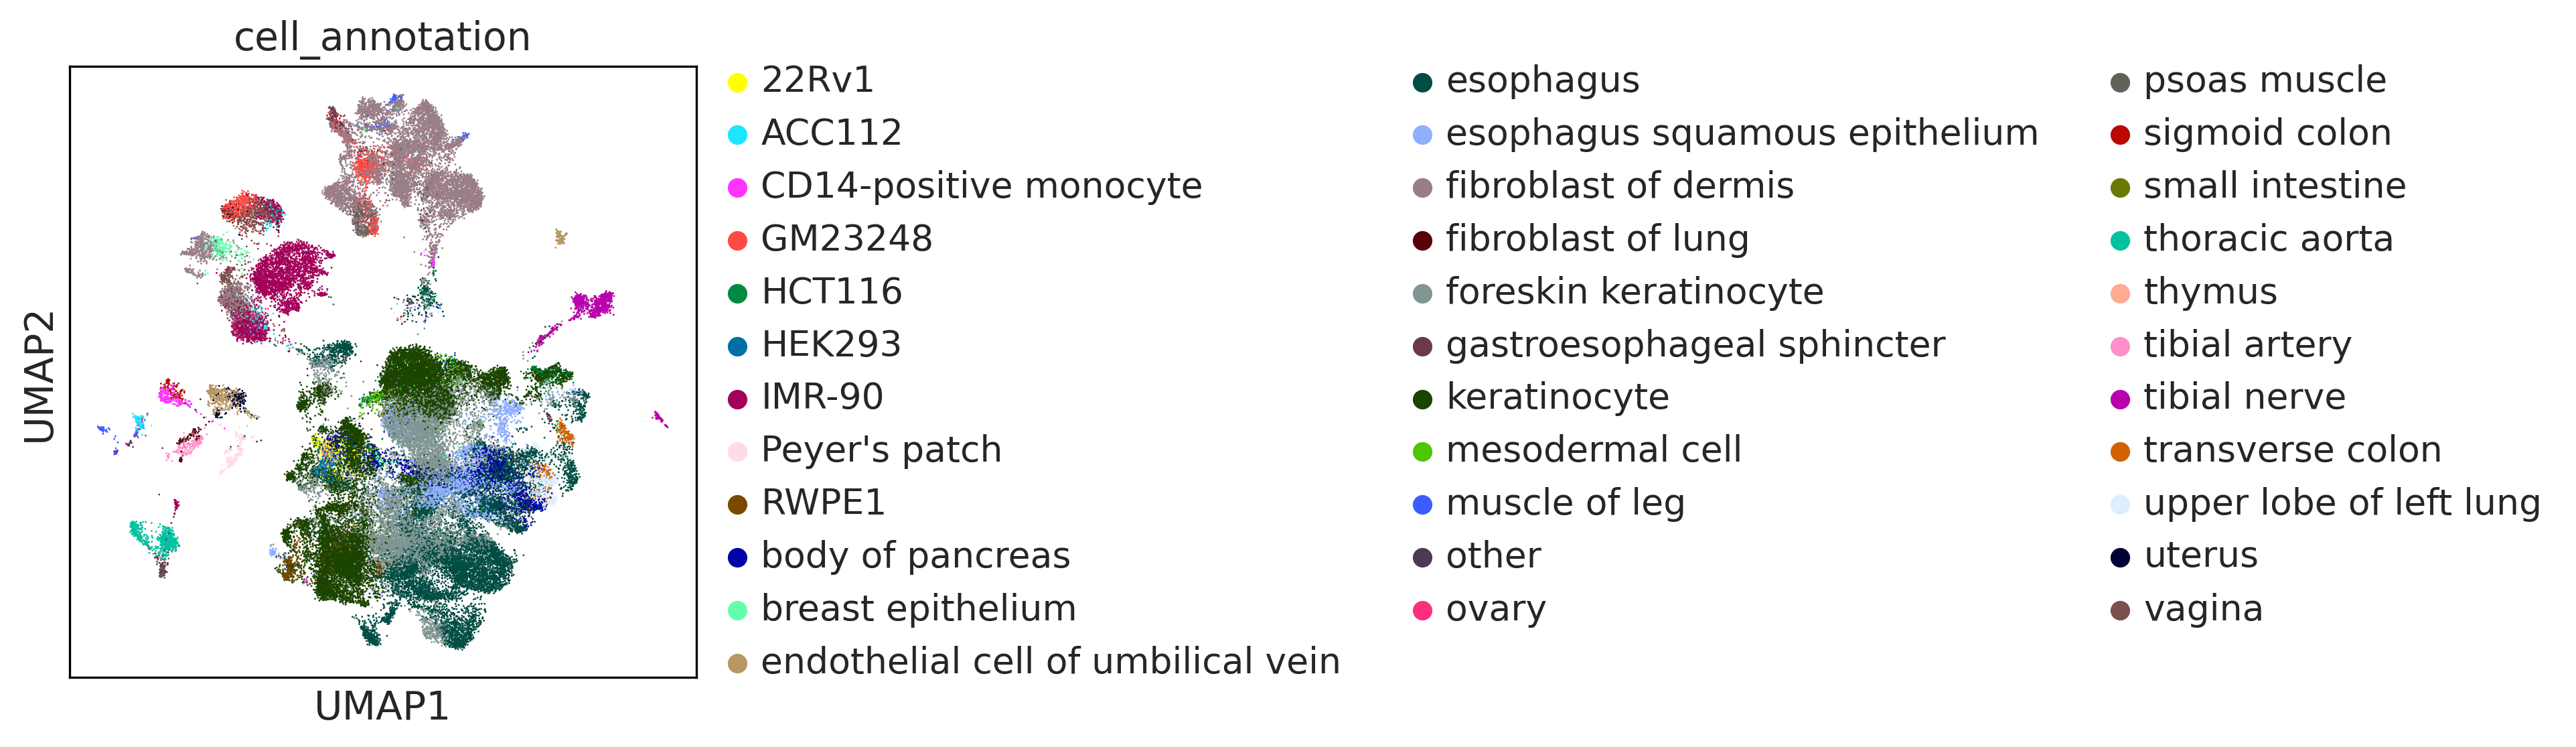

In [18]:
sc.pl.umap(adata, color="cell_annotation")

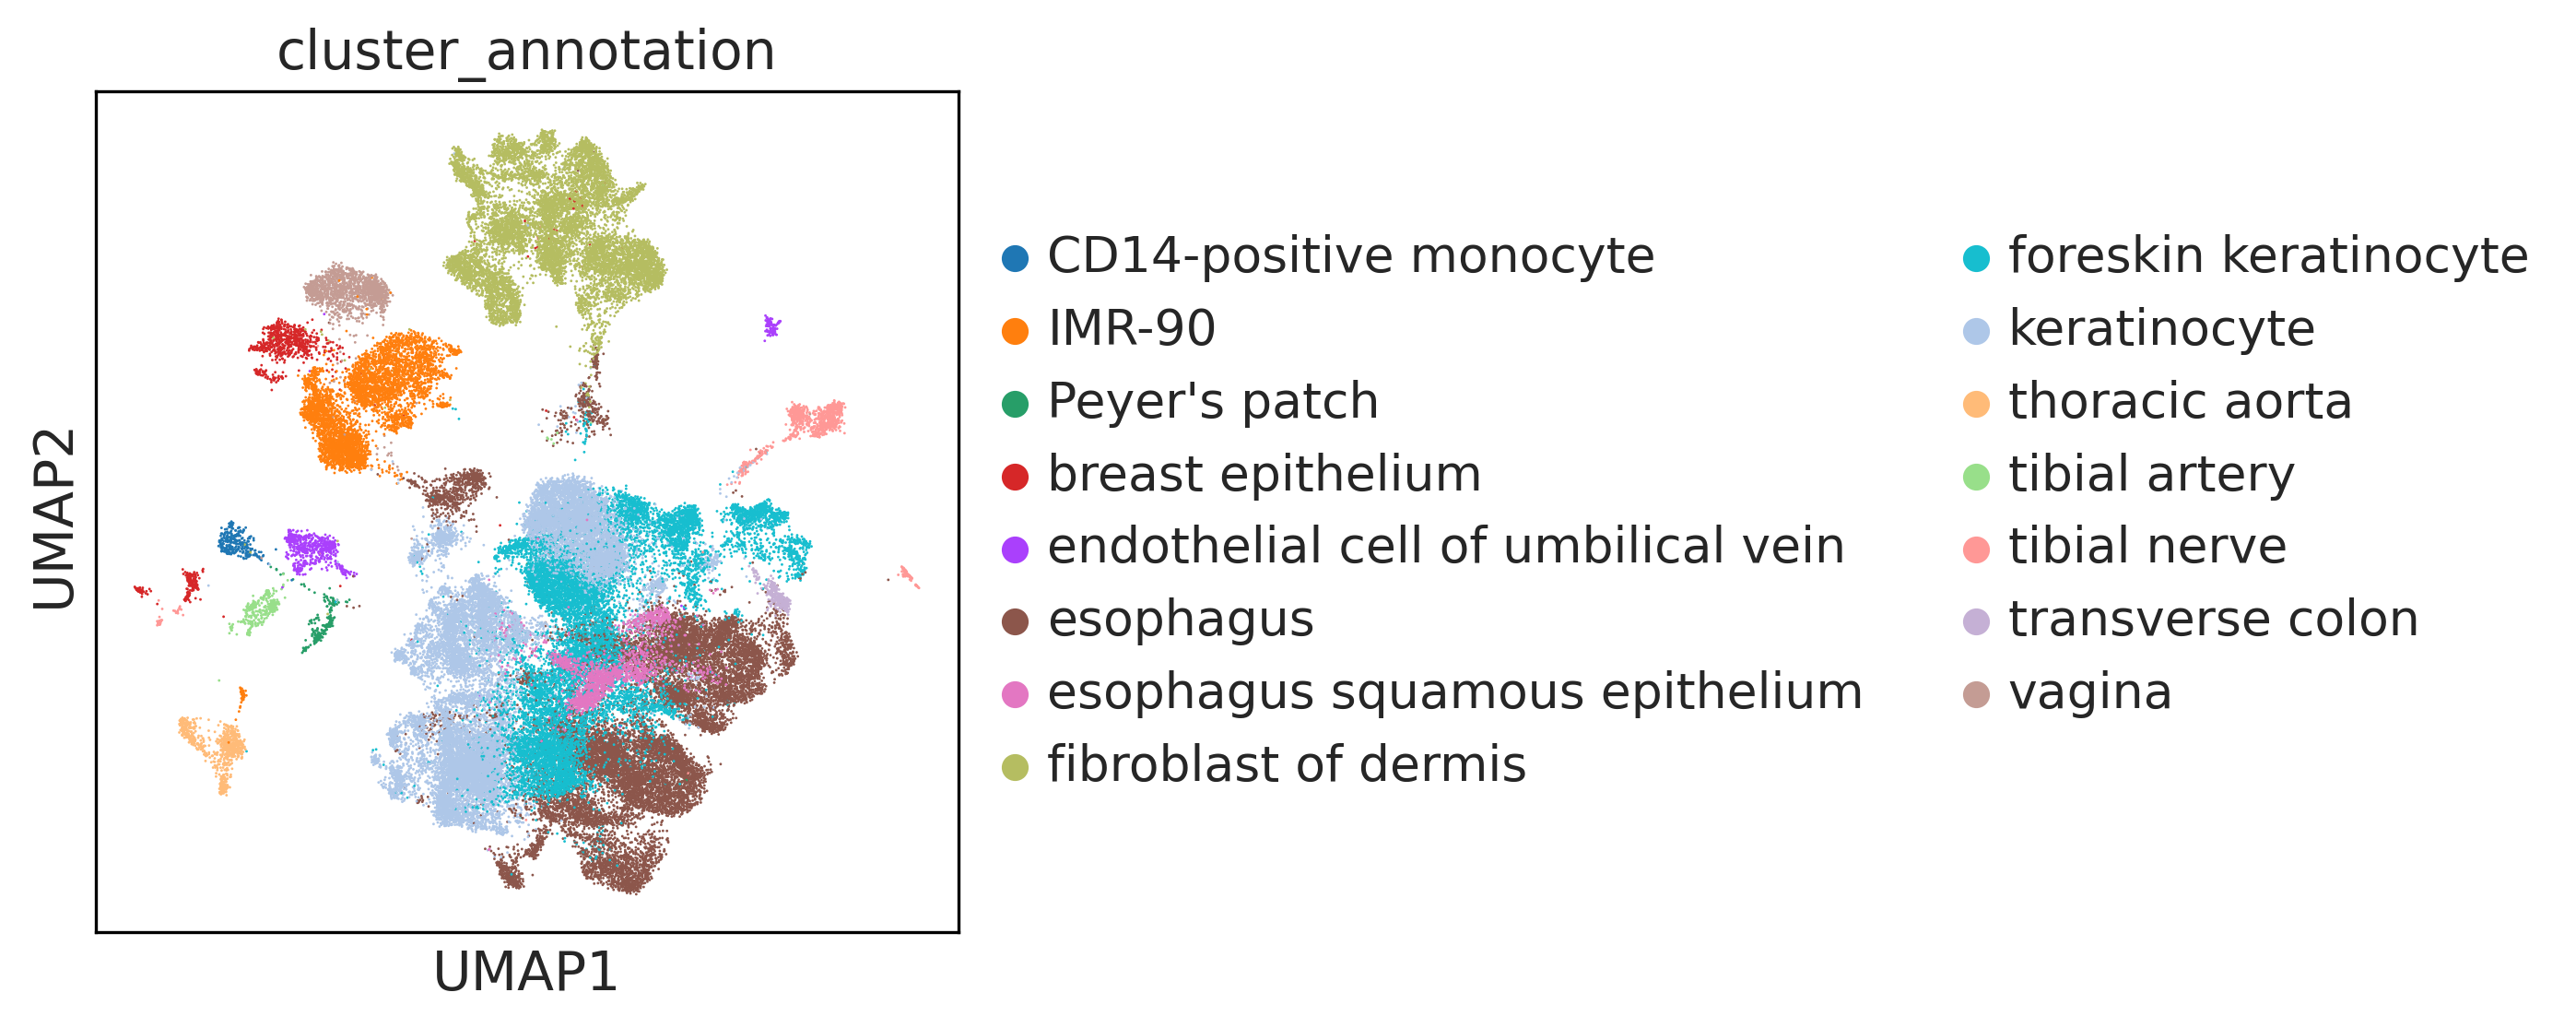

In [19]:
sc.pl.umap(adata, color="cluster_annotation")

The `scepia` cell type annotation only shows the most important cell type per single cell. However, the inferred H3K27ac profiles are a combination of multiple different cell types. Additionally, the cell types do not need to match perfectly to result in relevant motifs.

We can also create a confusion matrix to look at the cell type assignments.

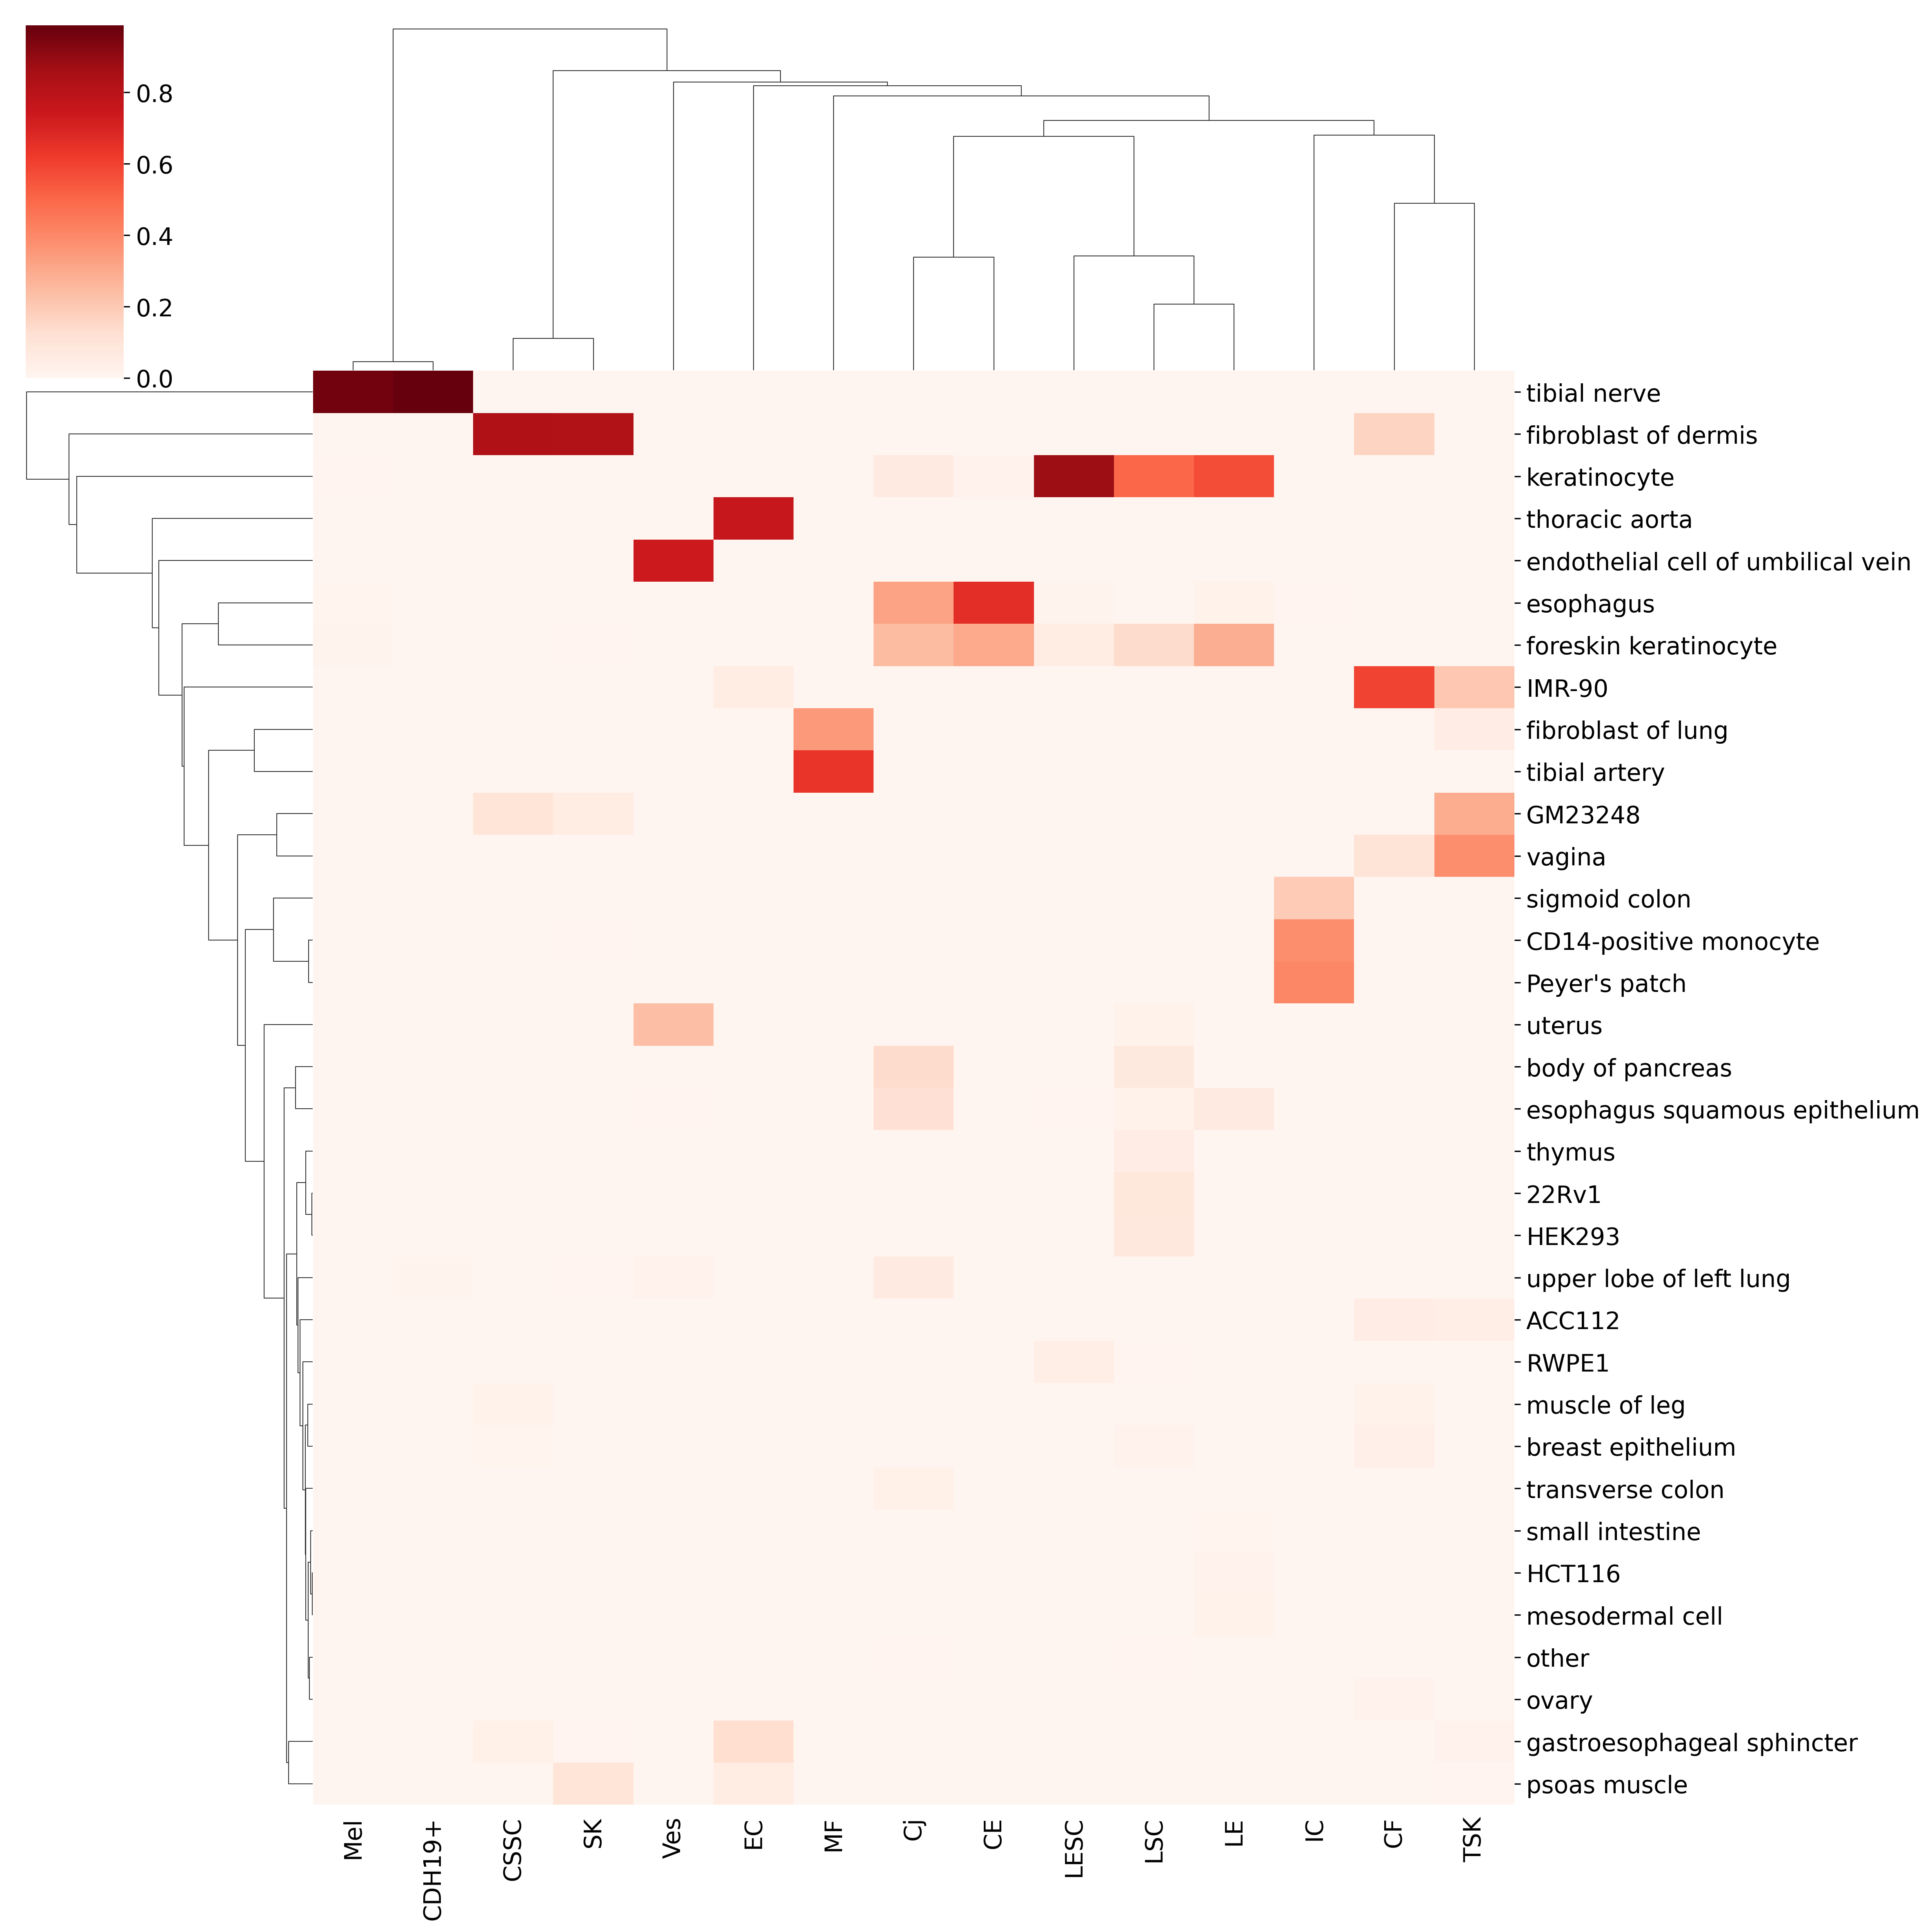

In [20]:
# perhaps this analysis is not nessesary?

labels = list(set(np.hstack((adata.obs["leiden_anno"].astype(str).unique(), adata.obs["cell_annotation"].astype(str).unique()))))

cnf_matrix = pd.DataFrame(confusion_matrix(adata.obs["leiden_anno"], adata.obs["cell_annotation"], labels=labels), index=labels, columns=labels)
cnf_matrix = cnf_matrix.loc[adata.obs["leiden_anno"].astype(str).unique(), adata.obs["cell_annotation"].astype(str).unique()]
cnf_matrix = cnf_matrix.div(cnf_matrix.sum(1), axis=0)
cm = sns.clustermap(cnf_matrix.T, cmap="Reds", figsize=(16,16))

# Motif activity

Most of the results from `infer_motifs()` are stored in `adata.uns['scepia']`. 

In [21]:
adata.uns["scepia"].keys()

dict_keys(['version', 'cell_types', 'pfm', 'motif_activity', 'correlation'])

The value of `adata.uns["scepia"]["correlation"]` is a pandas DataFrame with results of the correlation between inferred motif activity and expression of the transcription factor. This can be used to prioritize relevant motifs.

In [22]:
adata.uns["scepia"]["correlation"].sort_values("p_adj").head(20)

motif  correlation  abs_correlation  \
factor                                                                     
ELF3                       GM.5.0.Ets.0002     0.764541         0.764541   
PAX6               GM.5.0.Homeodomain.0043    -0.728278         0.728278   
KLF5                   GM.5.0.C2H2_ZF.0006     0.716644         0.716644   
KLF5                   GM.5.0.C2H2_ZF.0314     0.708124         0.708124   
EHF                        GM.5.0.Ets.0002     0.704185         0.704185   
KLF5                   GM.5.0.C2H2_ZF.0019     0.702028         0.702028   
KLF5                   GM.5.0.C2H2_ZF.0013     0.692775         0.692775   
KLF5                   GM.5.0.C2H2_ZF.0009     0.689866         0.689866   
PAX6    GM.5.0.Homeodomain_Paired_box.0001    -0.671067         0.671067   
KLF5                   GM.5.0.C2H2_ZF.0268     0.648460         0.648460   
SPI1                       GM.5.0.Ets.0010     0.624549         0.624549   
TWIST1                    GM.5.0.bHLH.0065     0.596015         0.596015   
FOXQ1                 GM.5.0.Forkhead.0001    -0.411908         0.411908   
SPI1                       GM.5.0.Ets.0015     0.616336         0.616336   
KLF5                   GM.5.0.C2H2_ZF.0213     0.632973         0.632973   
FOSL1                     GM.5.0.bZIP.0019     0.469360         0.469360   
FOXQ1                 GM.5.0.Forkhead.0044    -0.392242         0.392242   
ZEB1       GM.5.0.C2H2_ZF_Homeodomain.0001    -0.432454         0.432454   
KLF5                   GM.5.0.C2H2_ZF.0144     0.617281         0.617281   
ZEB1       GM.5.0.C2H2_ZF_Homeodomain.0002    -0.426579         0.426579   

                pval  permutation_pval      combined         p_adj  \
factor                                                               
ELF3    0.000000e+00          0.000010  0.000000e+00  0.000000e+00   
PAX6    1.921156e-07          0.000010  5.303450e-11  2.299046e-08   
KLF5    1.024616e-06          0.000010  2.659357e-10  7.685541e-08   
KLF5    1.665002e-06          0.000010  4.241733e-10  9.193957e-08   
EHF     2.113271e-06          0.000010  5.334051e-10  9.249245e-08   
KLF5    2.561541e-06          0.000010  6.416920e-10  9.272450e-08   
KLF5    5.187121e-06          0.000030  3.621400e-09  4.485363e-07   
KLF5    6.467891e-06          0.000030  4.473346e-09  4.847989e-07   
PAX6    1.562540e-05          0.000464  1.429916e-07  1.377486e-05   
KLF5    6.474295e-05          0.000710  8.226683e-07  7.132534e-05   
SPI1    1.650273e-04          0.000434  1.249731e-06  8.506068e-05   
TWIST1  3.905069e-04          0.000187  1.275420e-06  8.506068e-05   
FOXQ1   7.365775e-03          0.000010  1.266691e-06  8.506068e-05   
SPI1    2.196521e-04          0.000730  2.668364e-06  1.542314e-04   
KLF5    1.219294e-04          0.001243  2.530611e-06  1.542314e-04   
FOSL1   3.787174e-03          0.000069  4.224133e-06  2.213816e-04   
FOXQ1   9.190617e-03          0.000030  4.382616e-06  2.213816e-04   
ZEB1    5.801314e-03          0.000049  4.596157e-06  2.213816e-04   
KLF5    2.121596e-04          0.002249  7.420752e-06  3.386206e-04   
ZEB1    6.215067e-03          0.000089  8.500878e-06  3.685131e-04   

        -log10(p-value)  motif_stddev  
factor                                 
ELF3                inf      0.032763  
PAX6           7.638452      0.009102  
KLF5           7.114326      0.016923  
KLF5           7.036498      0.030805  
EHF            7.033894      0.032763  
KLF5           7.032805      0.029485  
KLF5           6.348202      0.022945  
KLF5           6.314438      0.023836  
PAX6           4.860913      0.014912  
KLF5           4.146756      0.019330  
SPI1           4.070271      0.016287  
TWIST1         4.070271      0.037038  
FOXQ1          4.070271      0.022911  
SPI1           3.811827      0.020204  
KLF5           3.811827      0.011837  
FOSL1          3.654859      0.013453  
FOXQ1          3.654859      0.014386  
ZEB1           3.654859      0.047369  
KLF5           3.470287

You can visualize the inferred TF activity with the normal scanpy plotting functions, using `{FACTOR_NAME}_activity`. For instance, to plot the activity of two of the top factor, CEBPD and SPI1 (also known as PU.1):

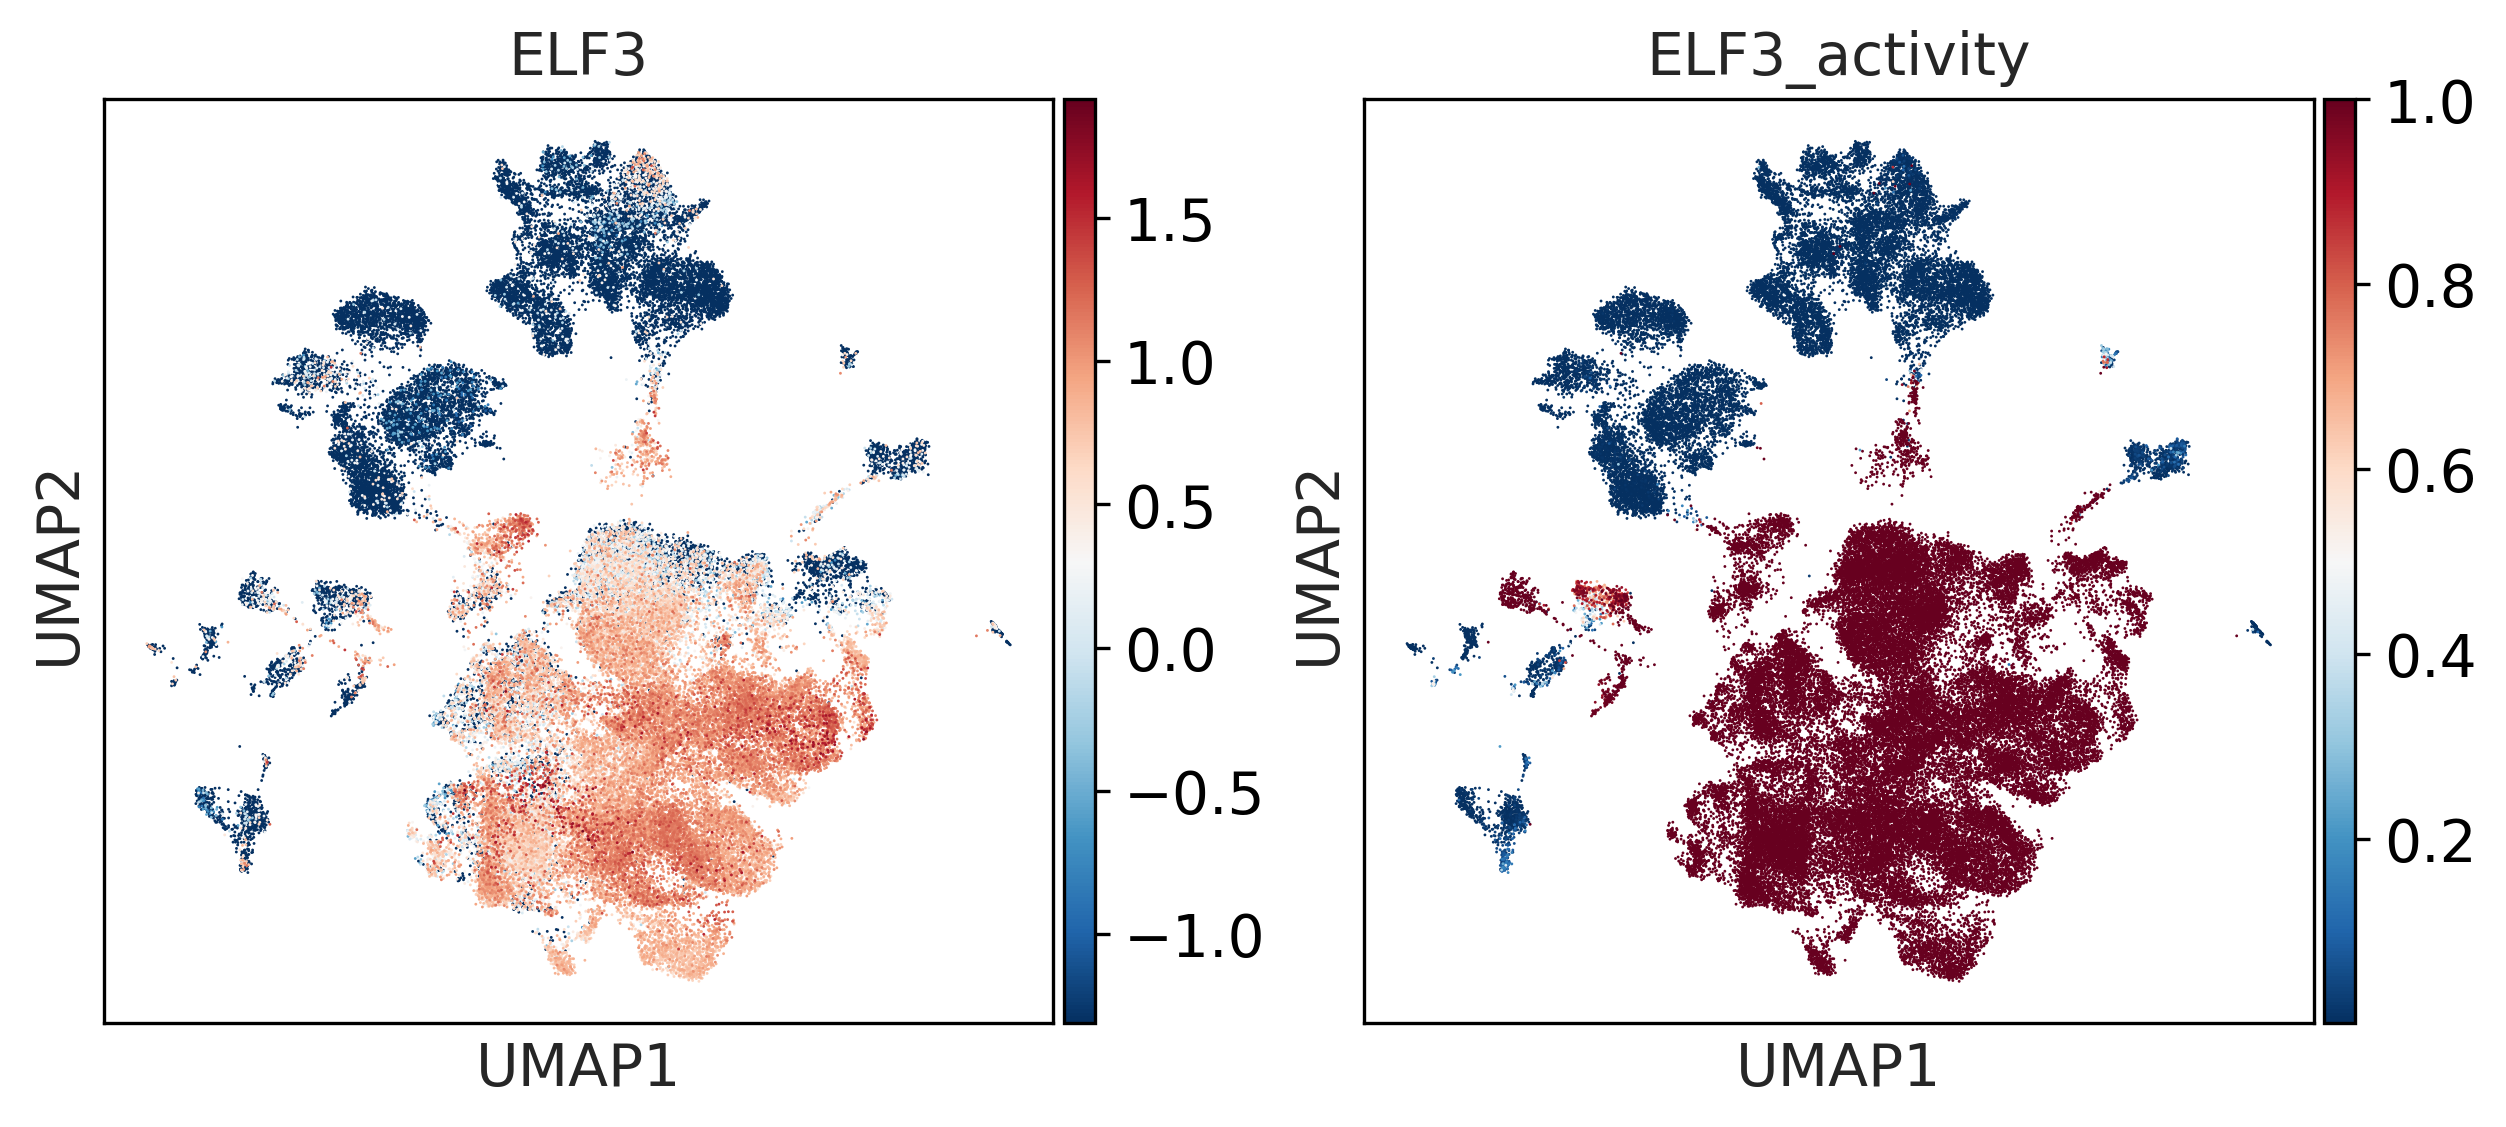

In [23]:
sc.pl.umap(adata, color=["ELF3", "ELF3_activity"], cmap="RdBu_r")

**Please note:** this TF activity is based on the motif for that factor with the highest correlation. However, sometimes this assumption is incorrect. You can always check other motifs. 

In [24]:
f2m = adata.uns["scepia"]['correlation']
f2m.loc["CEBPD"].sort_values("p_adj").head(5)

motif  correlation  abs_correlation      pval  \
factor                                                             
CEBPD   GM.5.0.bZIP.0052     0.190993         0.190993  0.085910   
CEBPD   GM.5.0.bZIP.0039    -0.089548         0.089548  0.234624   
CEBPD   GM.5.0.bZIP.0061     0.011100         0.011100  0.458378   

        permutation_pval  combined     p_adj  -log10(p-value)  motif_stddev  
factor                                                                       
CEBPD           0.093984  0.046984  0.132689         0.877166      0.016158  
CEBPD           0.280256  0.244728  0.360848         0.442675      0.013120  
CEBPD           0.470878  0.546770  0.571476         0.243002      0.009290

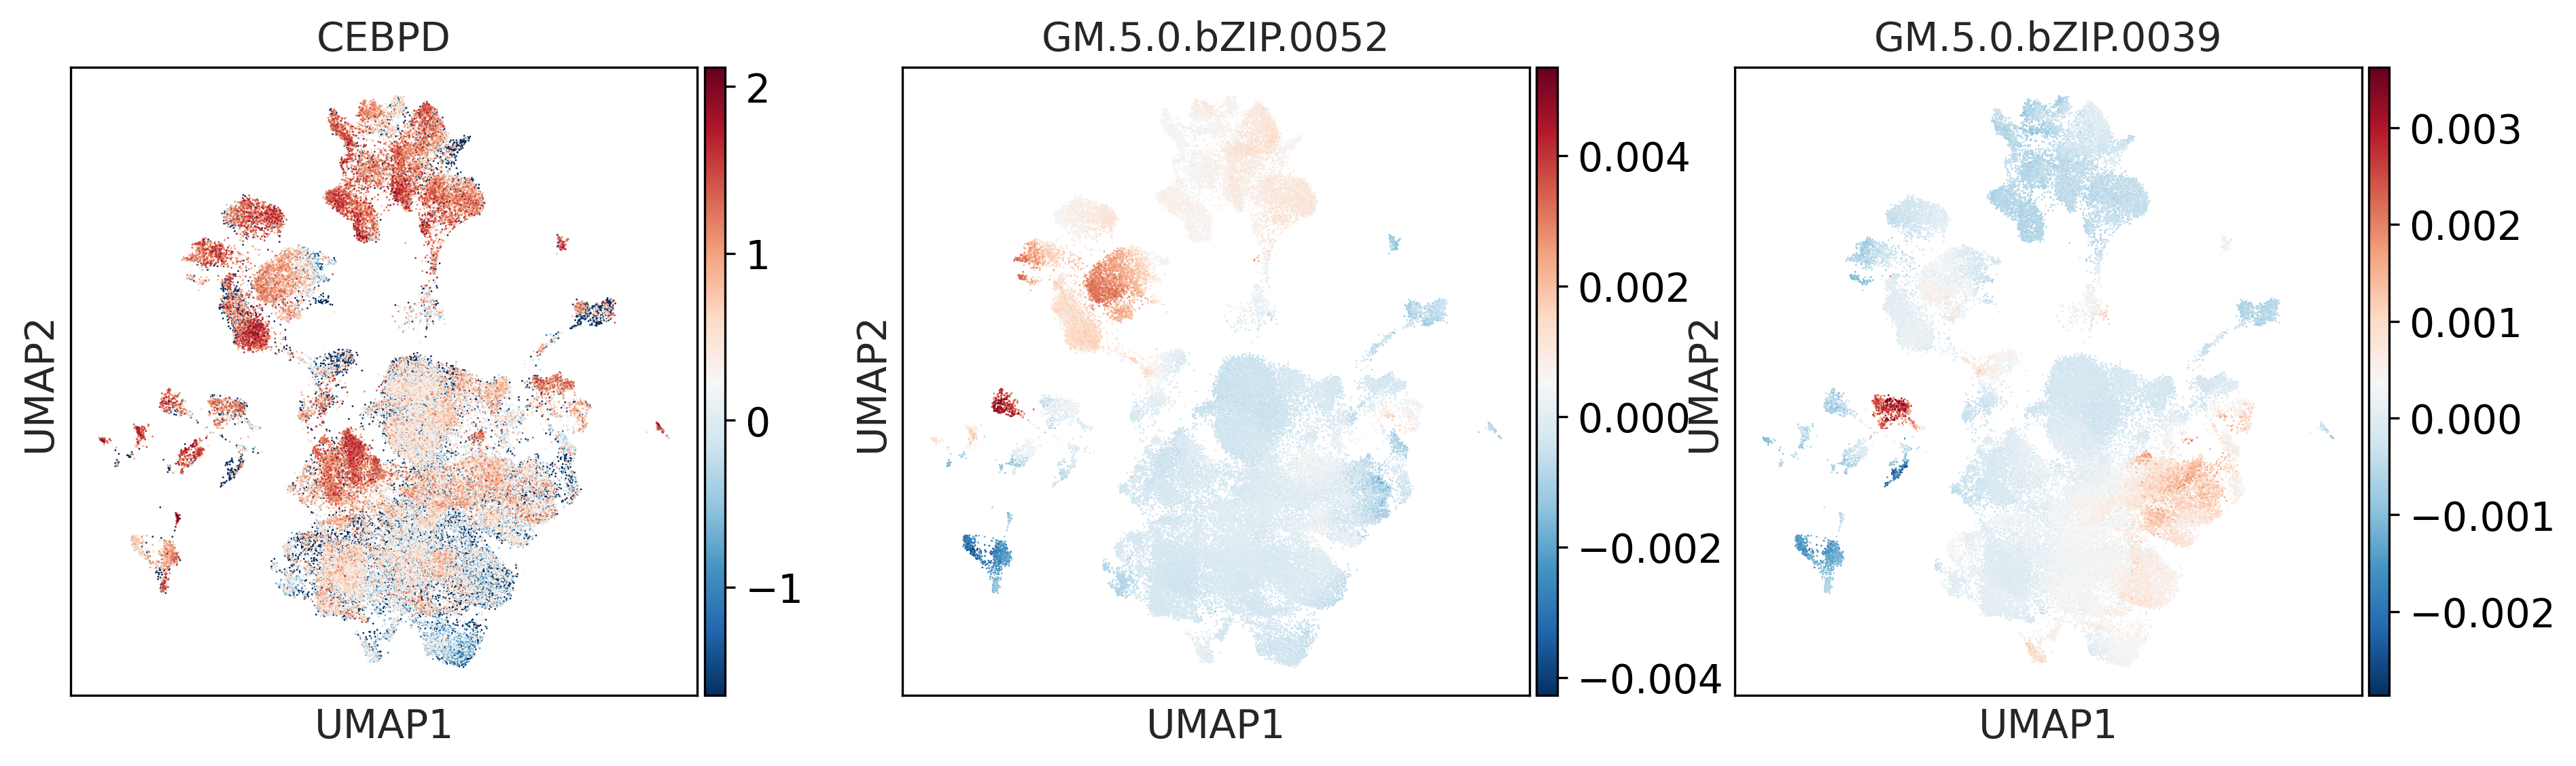

In [25]:
sc.pl.umap(adata, color=["CEBPD", "GM.5.0.bZIP.0052", "GM.5.0.bZIP.0039"], cmap="RdBu_r")

You can plot the correlated between TF and motif activity and the significance (-log10 of the p-value) in a volcano plot.

posx and posy should be finite values
/vol/mbconda/julian/envs/scepia_050/lib/python3.9/site-packages/matplotlib/transforms.py:384: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 1] - points[0, 1]
posx and posy should be finite values
posx and posy should be finite values


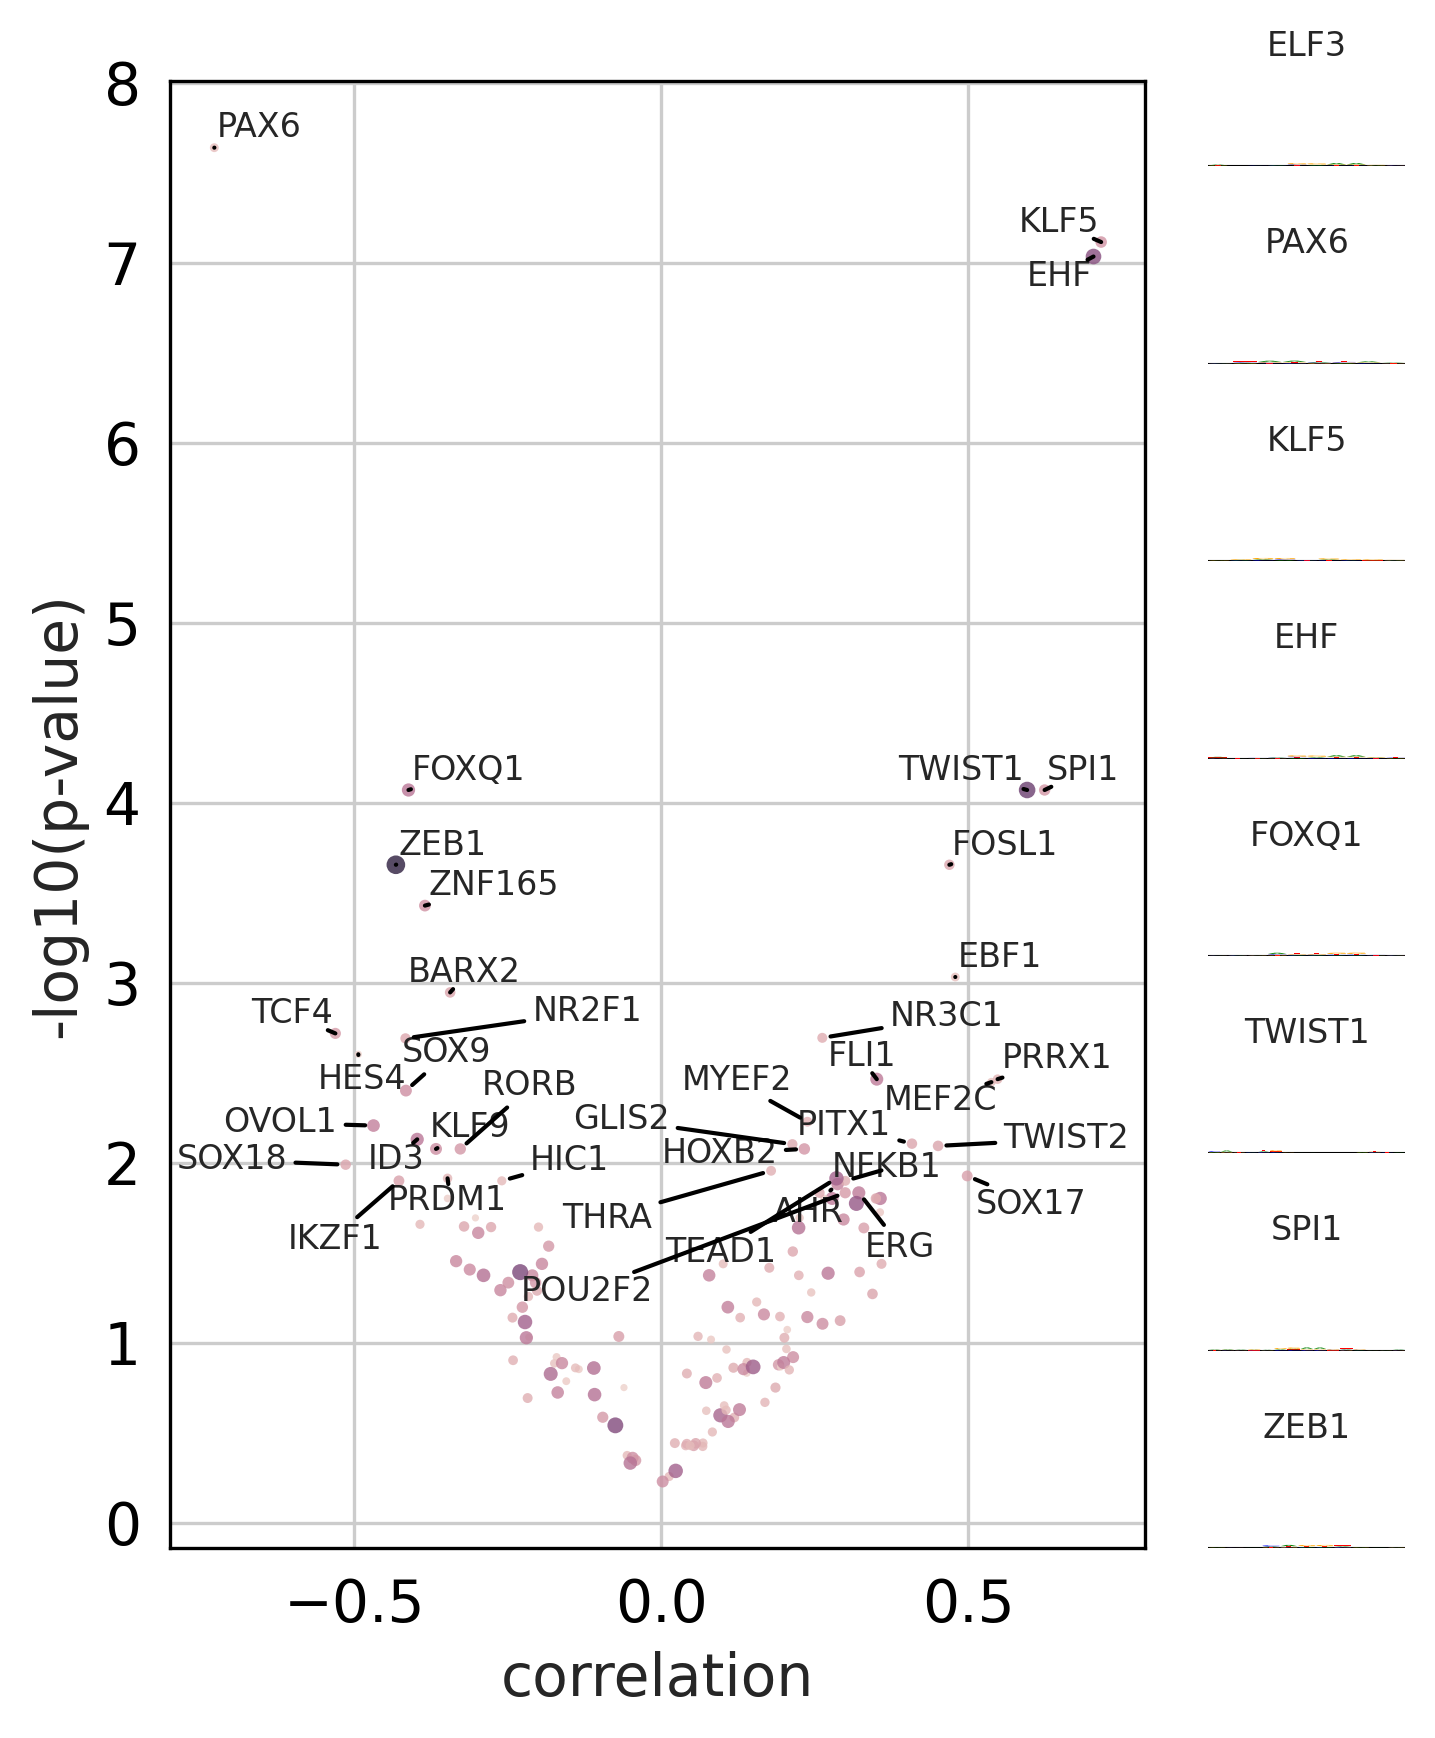

In [26]:
ax = plot(adata, n_anno=40)

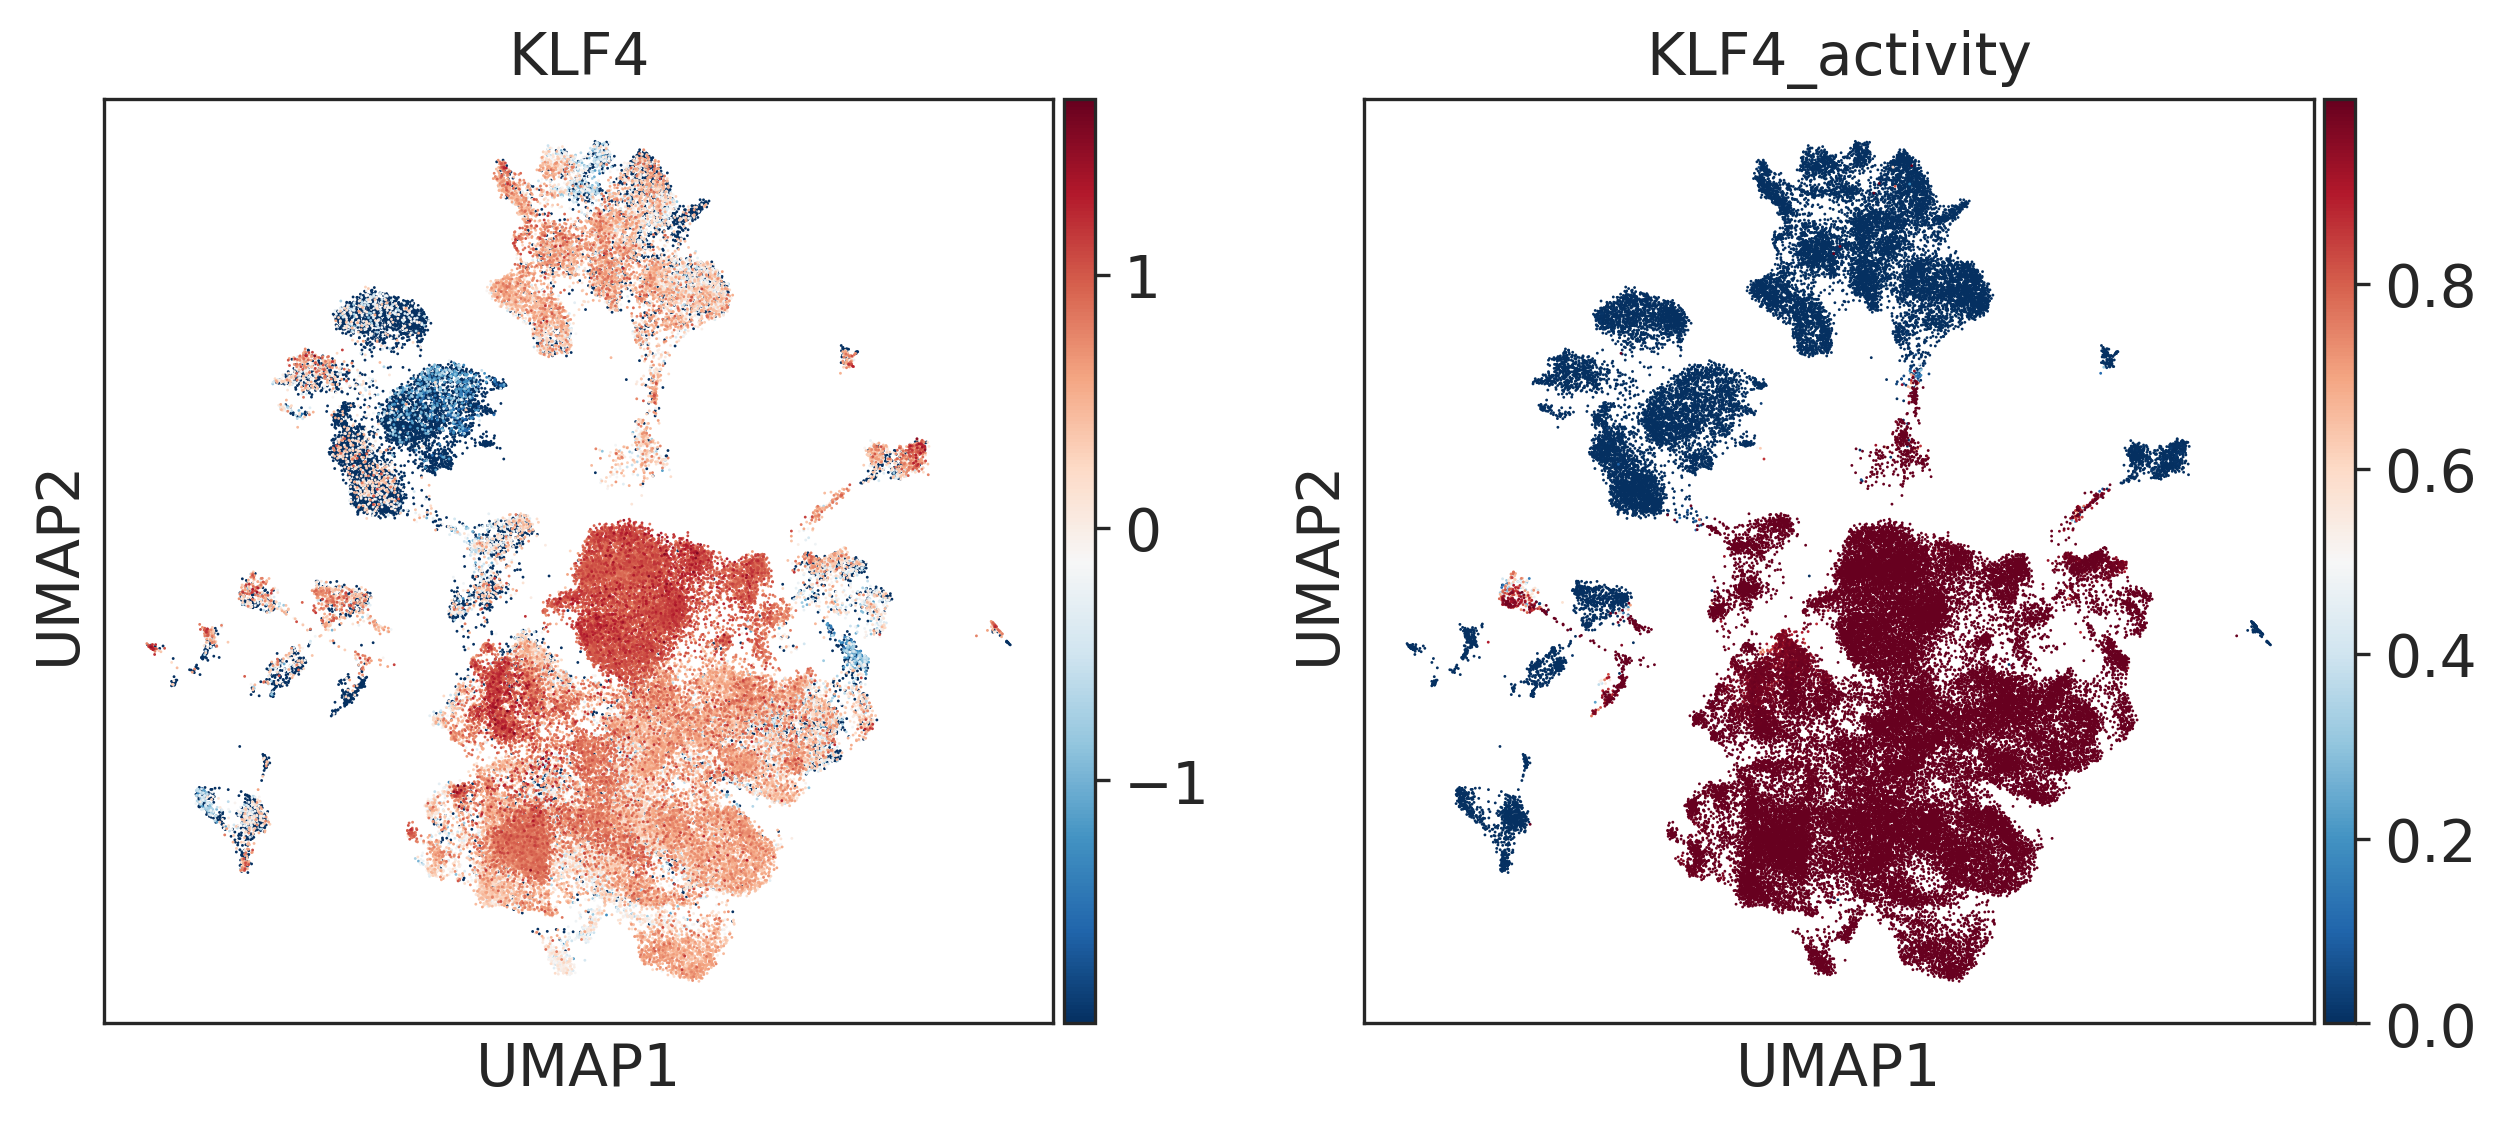

In [27]:
sc.pl.umap(adata, color=["KLF4", "KLF4_activity"], cmap="RdBu_r")

# Saving SCEPIA results

You can save and load the `AnnData` object as normal.

In [28]:
adata.uns['scepia']["cell_types"] = list(adata.uns['scepia']["cell_types"])

In [29]:
adata.write('meta.scepia_0205.h5ad')

In [30]:
adata = sc.read('meta.scepia_0205.h5ad')

In [31]:
adata

AnnData object with n_obs × n_vars = 65036 × 2744
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.15', 'seurat_clusters', 'costum_clustering', 'Condition', 'pANN_0.25_0.06_1806', 'DF.classifications_0.25_0.06_1806', 'pANN_0.25_0.005_1289', 'DF.classifications_0.25_0.005_1289', 'RNA_snn_res.0.1', 'pANN_0.25_0.18_1347', 'DF.classifications_0.25_0.18_1347', 'pANN_0.25_0.14_831', 'DF.classifications_0.25_0.14_831', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0.0', 'leiden_0.05', 'leiden_0.1', 'leiden_0.15', 'leiden_0.2', 'leiden_0.25', 'leiden_0.3', 'leiden_0.35', 'leiden_0.4', 'leiden_0.45', 'leiden_0.5', 'leiden_0.55', 'leiden_0.6', 'leiden_0.65', 'leiden_0.7', 'leiden_0.75', 'leiden_0.8', 'leiden_0.85', 'leiden_0.9', 'leiden_0.95', 'leiden_anno', 'louvain', 'n_counts', 'cluster_annotation', 'cell_annotation', 'GM.5.0.Sox.0001', 'GM.5.0.Homeodomain.0001', 'GM.5.0.Mixed.0001', 'GM.5.0.Nuclear_rec

In [32]:
# Generating a pseudobulk score of all motifs from each cell population
data_list = []

for i in adata.obs["leiden_anno"].astype(str).unique():
    
    # Selecting rows that match each populations
    sel_cols = [col for col in adata.obs.columns if 'GM' in col]
    sel_cols.append("leiden_anno") 
    adata_sel = adata.obs[sel_cols]
    adata_sel=adata_sel[adata_sel['leiden_anno']==i]
    adata_sel.drop('leiden_anno',axis=1,inplace=True)
    
    # Calculate the means
    data = pd.DataFrame(adata_sel.mean(), columns=['mean_values'])
    data.rename(columns={'mean_values': i}, inplace=True)
    
    # Joining the list of scores to list of lists
    data_list.append(data[i].tolist())

# Joining the list_of_lists to a new dataframe
full = pd.DataFrame(data_list, columns=[col for col in adata.obs.columns if 'GM' in col],index=adata.obs["leiden_anno"].astype(str).unique())
full.index = full.index.astype(str)+'_scepia'
full.to_csv("pseudobulk_02052022_meta.tsv", sep="\t", index=True)